In [ ]:
pip install opencv-python


In [ ]:
pip install matplotlib


In [ ]:
pip install tensorflow


In [5]:
import tensorflow as tf
import os

In [6]:
import cv2
import imghdr

In [7]:
data_dir='Data'

In [8]:
image_exts= ["jpeg",'jpg','bmp','png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('Data')

Found 173 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()


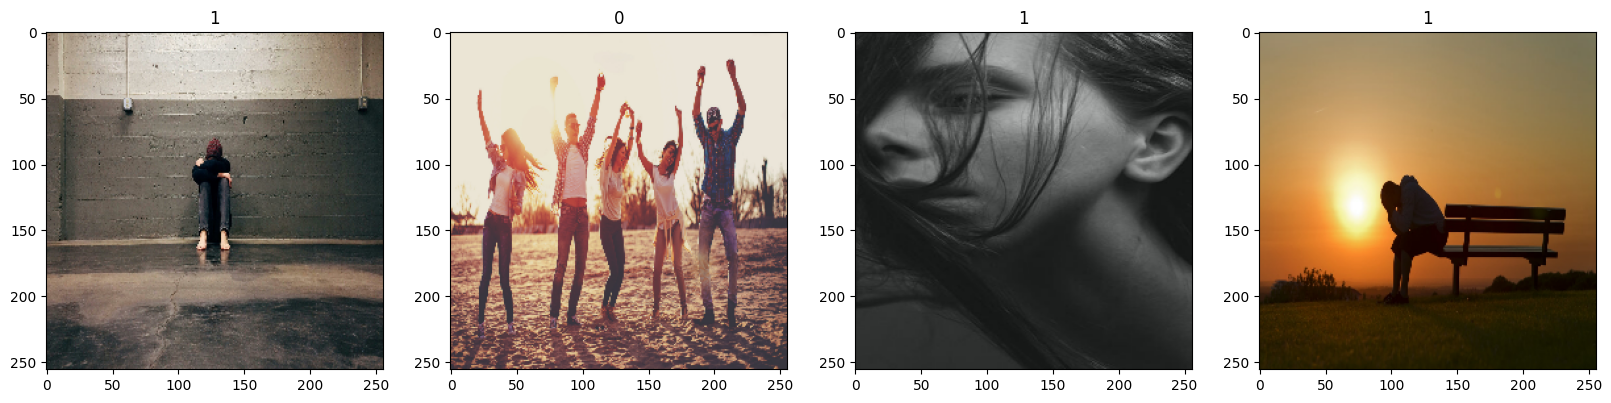

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [15]:
data= data.map(lambda x,y:(x/255,y))

In [16]:
len(data)

6

In [ ]:
data.as_numpy_iterator().next()


In [18]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1


In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [20]:
len(test)

1

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [47]:
model = Sequential()

In [49]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [51]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [53]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
logdir='logs'

In [57]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist=model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

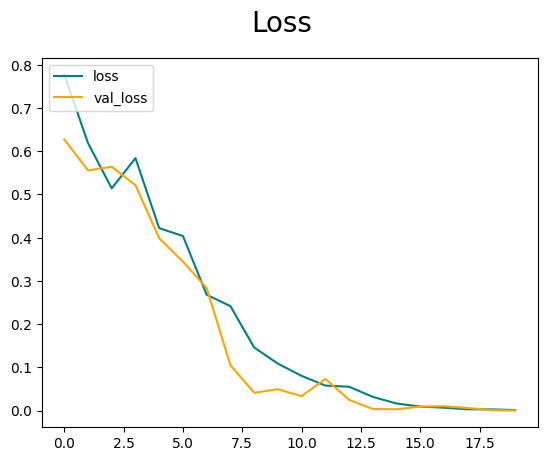

In [61]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

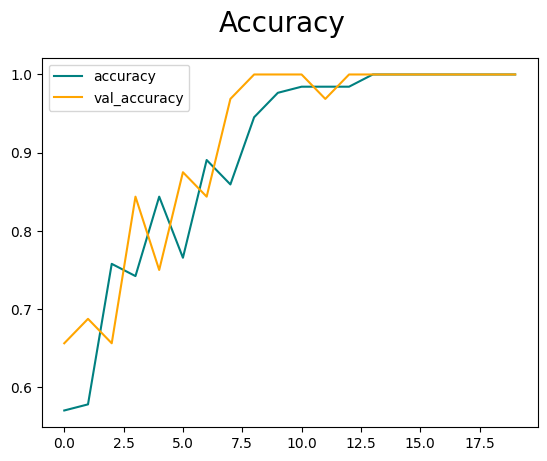

In [63]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [65]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [67]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [69]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


In [71]:
print(pre.result(), re.result(), acc.result())


tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


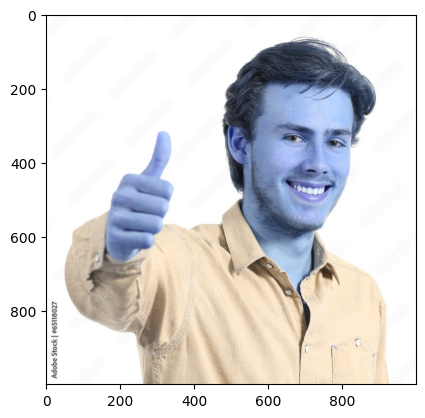

In [77]:
img = cv2.imread('Data\happytest.jpg')
plt.imshow(img)
plt.show()

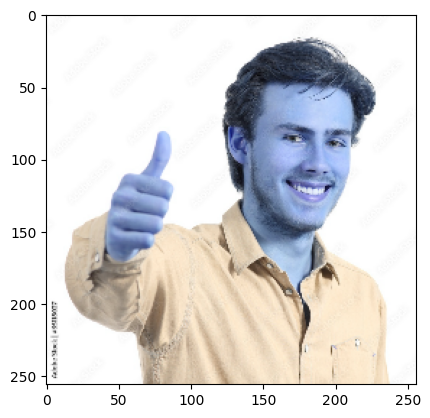

In [79]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [81]:
yhat = model.predict(np.expand_dims(resize/255, 0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [83]:
yhat


array([[0.07347501]], dtype=float32)

In [85]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


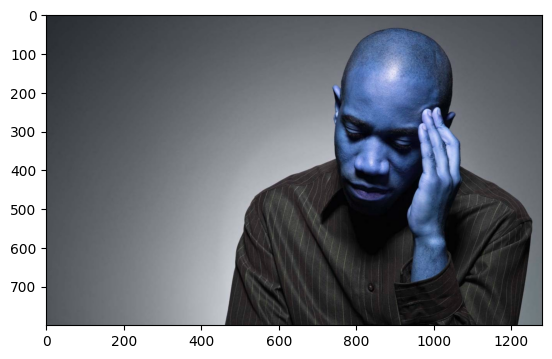

In [87]:
img = cv2.imread('Data\sadtest.jpg')
plt.imshow(img)
plt.show()

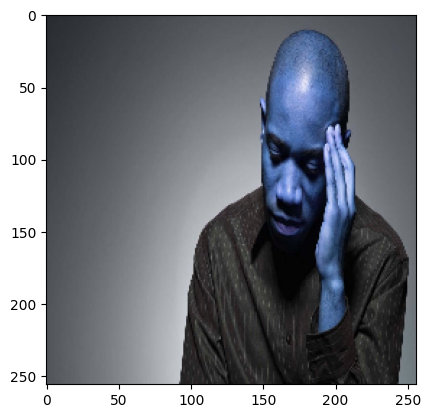

In [89]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [91]:
yhat = model.predict(np.expand_dims(resize/255, 0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [93]:
yhat

array([[0.9955256]], dtype=float32)

In [95]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


In [97]:
from tensorflow.keras.models import load_model


In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))


new_model = load_model('models\imageclassifier.h5')


In [105]:
new_model.predict(np.expand_dims(resize/255, 0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


array([[0.9955256]], dtype=float32)